# **Car Price Prediction**

**Mục tiêu:**
Xây dựng Pipeline học máy truyền thống cho vấn đề trên.

1.  **EDA (Exploratory Data Analysis):**
    *   Thống kê mô tả dữ liệu, trực quan hóa để hiểu rõ các biến.
    *   Phát hiện dữ liệu thiếu, giá trị ngoại lai và xu hướng phân phối.

2.  **Tiền xử lý dữ liệu (Data Preprocessing):**
    *   Làm sạch dữ liệu, xử lý các giá trị bị thiếu.
    *   Mã hóa dữ liệu phân loại (One-Hot Encoding, Label Encoding).
    *   Chuẩn hóa dữ liệu số (StandardScaler, MinMaxScaler).
    *   Chia tập dữ liệu thành tập huấn luyện (train) và tập kiểm tra (test).

3.  **Trích xuất và lựa chọn đặc trưng (Feature Engineering & Selection):**
    *   Tạo ra các đặc trưng mới có ý nghĩa hơn từ dữ liệu gốc (ví dụ: tuổi của xe).
    *   Lựa chọn những đặc trưng quan trọng nhất để đưa vào mô hình.

4.  **Huấn luyện mô hình (Model Training):**
    *   Áp dụng các thuật toán học máy phù hợp cho bài toán **hồi quy (regression)** như:
        *   Linear Regression
        *   SVR (1 type of SVM)
        *   Random Forest

5.  **Đánh giá mô hình (Model Evaluation):**
    *   Sử dụng các chỉ số đánh giá cho bài toán hồi quy:
        *   MAE (Mean Absolutely Error)
        *   RMSE (Mean Square Of Error)
        *  R^2 (The Coefficient Of Determination)

**Yêu cầu:**
* Các nhóm không được chọn trùng tập dữ liệu.
* Tập dữ liệu phải có missing value để sinh viên thực hành kỹ thuật imputation.
* Tập dữ liệu phải có categorical value để sinh viên thực hành các kỹ thuật
encoding.
* Số lượng mẫu (sample size) đủ lớn để pipeline có ý nghĩa; việc lựa chọn cụ thể
nên được thảo luận trực tiếp với giảng viên trên lớp.

**Nhiệm vụ:** mỗi nhóm phải xây dựng một pipeline học máy truyền thống cho
dữ liệu dạng bảng. Pipeline này phải được thiết kế sao cho cho phép cấu hình các kỹ
thuật và tham số ở từng bước. Ví dụ:
* Scaling: có thể lựa chọn MinMaxScaler hoặc StandardScaler; nếu chọn MinMaxScaler,
sinh viên cần cấu hình feature_range.
* Giảm số chiều: có thể lựa chọn PCA với các mức giữ lại phương sai khác nhau
(90%, 95%, ...).
* Mô hình: có thể lựa chọn Logistic Regression, SVM, Random Forest và so sánh
kết quả.

Kết quả cuối cùng cần bao gồm: báo cáo phân tích EDA, mô tả pipeline, các tham
số đã thử nghiệm, và so sánh hiệu quả giữa các cấu hình.

## **1. Thiết lập môi trường và Tải dữ liệu**



### **1.1 Import thư viện và cấu hình Kaggle API từ Secrets**

In [2]:
import os, json, warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

from google.colab import userdata
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.decomposition import PCA
from IPython.display import display, Markdown


from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

print("Các thư viện đã được import và cấu hình.")

# Tự động cấu hình Kaggle API
os.environ['KAGGLE_USERNAME'] = 'nguyenk512'
os.environ['KAGGLE_KEY'] = '187454a718c857637f7319f39e33b509'

Các thư viện đã được import và cấu hình.


### **1.2 Tải, giải nén và đọc dữ liệu**

In [3]:
!pip install kaggle --quiet
!kaggle datasets download -d deepcontractor/car-price-prediction-challenge -p ./data

# Thêm cờ -o để tự động ghi đè file cũ, tránh bị hỏi và gây lỗi
!unzip -o -q ./data/car-price-prediction-challenge.zip -d ./data

# Đọc file 'car_price_prediction.csv' (đây là file dữ liệu huấn luyện)
try:
    df = pd.read_csv('./data/car_price_prediction.csv')
    print("\nĐọc dataset thành công!")
except FileNotFoundError:
    print("\nLỗi: Không tìm thấy dataset. Vui lòng kiểm tra lại kết quả lệnh 'ls' ở trên.")

Dataset URL: https://www.kaggle.com/datasets/deepcontractor/car-price-prediction-challenge
License(s): CC0-1.0
car-price-prediction-challenge.zip: Skipping, found more recently modified local copy (use --force to force download)

Đọc dataset thành công!


### **1.3 Cấu hình các kỹ thuật và tham số kỹ thuật**

In [4]:
# ----------------------------
# 0) CONFIG (chỉnh ở đây)
# ----------------------------
CONFIG = {
    "download_from_kaggle": True,                 # đặt False nếu đã có file csv sẵn
    "kaggle_dataset": "deepcontractor/car-price-prediction-challenge",
    "data_dir": "./data",
    "csv_name": "car_price_prediction.csv",
    "target": "Price",

    # EDA lưu nhẹ nhàng
    "out_dir": "./runs/car_price",
    "save_figures": True,

    # Tiền xử lý đặc thù bộ dữ liệu này
    "parse_columns": True,     # Levy/Mileage/Engine volume/Doors
    "year_col": "Prod. year",
    "create_car_age": True,    # Car_Age = 2025 - Prod. year
    "car_age_year": 2025,

    # Xử lý ngoại lai IQR (học ngưỡng trên train để tránh leak)
    "clip_outliers": True,
    "outlier_cols": ["Mileage", "Levy"],  # cột số sẽ clip theo IQR
    "outlier_factor": 1.5,   # IQR factor

    # Split
    "test_size": 0.2,
    "random_state": 42,

    # Scaler cho biến số
    "scaler": "standard",     # "standard" | "minmax" | None
    "minmax_range": (0.0, 1.0),

    # PCA
    "apply_pca": True,
    "pca_variance_keep": 0.90,  # 0.90 / 0.95 / 0.99

    # Chọn model: "linear" | "svr" | "rf"
    "model_name": "rf",

    # GridSearch cho từng model
    "cv_folds": 3,
    "param_grids": {
        "linear": {},  # baseline
        "svr": {
            "model__kernel": ["rbf"],
            "model__C": [1.0, 10.0, 100.0],
            "model__epsilon": [0.1, 0.2, 0.5],
            "model__gamma": ["scale", "auto"]
        },
        "rf": {
            "model__n_estimators": [200, 400],
            "model__max_depth": [None, 10, 20],
            "model__min_samples_split": [2, 5],
            "model__min_samples_leaf": [1, 2],
            "model__max_features": ["sqrt", "log2"]
        }
    }
}

os.makedirs(CONFIG["data_dir"], exist_ok=True)
os.makedirs(CONFIG["out_dir"], exist_ok=True)

## **2. EDA (Exploratory Data Analysis) và Tiền xử lí (Data Preprocessing)**

### **2.1 Tổng quan dữ liệu**

#### **Thông tin tổng quan về các cột**

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19237 entries, 0 to 19236
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ID                19237 non-null  int64  
 1   Price             19237 non-null  int64  
 2   Levy              19237 non-null  object 
 3   Manufacturer      19237 non-null  object 
 4   Model             19237 non-null  object 
 5   Prod. year        19237 non-null  int64  
 6   Category          19237 non-null  object 
 7   Leather interior  19237 non-null  object 
 8   Fuel type         19237 non-null  object 
 9   Engine volume     19237 non-null  object 
 10  Mileage           19237 non-null  object 
 11  Cylinders         19237 non-null  float64
 12  Gear box type     19237 non-null  object 
 13  Drive wheels      19237 non-null  object 
 14  Doors             19237 non-null  object 
 15  Wheel             19237 non-null  object 
 16  Color             19237 non-null  object

#### **Kiểm tra missing value**

In [6]:
df.isna().sum()

,0
ID,0
Price,0
Levy,0
Manufacturer,0
Model,0
Prod. year,0
Category,0
Leather interior,0
Fuel type,0
Engine volume,0


#### **Kiểm tra trùng lặp dữ liệu**

In [7]:
print("Dữ liệu bị trùng lặp: ", df.duplicated().sum())
print("Tỉ lệ dữ liệu bị trùng lặp: ", df.duplicated().sum() * 100 / len(df), "%")
df.drop_duplicates(inplace=True)
print("\nDữ liệu sau khi loại bỏ trùng lặp: ")
df.shape

Dữ liệu bị trùng lặp:  313
Tỉ lệ dữ liệu bị trùng lặp:  1.6270728284035971 %

Dữ liệu sau khi loại bỏ trùng lặp: 


(18924, 18)

### **2.2 Thống kê mô tả cơ bản**



#### **2.2.1 Phân tích các biến số (Numerical Variables)**


In [8]:
df.describe(include="number")

,ID,Price,Prod. year,Cylinders,Airbags
count,1.892400e+04,1.892400e+04,18924.000000,18924.000000,18924.000000
mean,4.557538e+07,1.858744e+04,2010.914236,4.580216,6.568379
std,9.375468e+05,1.921356e+05,5.665749,1.200223,4.322323
min,2.074688e+07,1.000000e+00,1939.000000,1.000000,0.000000
25%,4.569501e+07,5.331000e+03,2009.000000,4.000000,4.000000
50%,4.577191e+07,1.317200e+04,2012.000000,4.000000,6.000000
75%,4.580174e+07,2.206300e+04,2015.000000,4.000000,12.000000
max,4.581665e+07,2.630750e+07,2020.000000,16.000000,16.000000


#### **2.2.2 Phân tích các biến phân loại (Categorical Variables)**


In [9]:
df.describe(include="object")

,Levy,Manufacturer,Model,Category,Leather interior,Fuel type,Engine volume,Mileage,Gear box type,Drive wheels,Doors,Wheel,Color
count,18924,18924,18924,18924,18924,18924,18924,18924,18924,18924,18924,18924,18924
unique,559,65,1590,11,2,7,107,7687,4,3,3,2,16
top,-,HYUNDAI,Prius,Sedan,Yes,Petrol,2,0 km,Automatic,Front,04-May,Left wheel,Black
freq,5709,3729,1069,8600,13731,9944,3856,714,13282,12695,18032,17471,4944


In [10]:


# Lấy danh sách các cột dạng phân loại
categorical_cols = df.select_dtypes(include=['object']).columns

def summarize_categorical_column(col_name):
    """
    Tóm tắt thông tin của một cột phân loại một cách trực quan và đầy đủ,
    gom mọi thứ vào một khối duy nhất.
    """

    # --- 1. Thu thập thông tin ---
    value_counts = df[col_name].value_counts()
    nunique = df[col_name].nunique()
    missing_count = df[col_name].isnull().sum()

    # --- 2. Tạo và hiển thị bảng tóm tắt bằng Markdown ---
    summary_md = f"""
<div style="border: 1px solid #e0e0e0; padding: 15px; border-radius: 5px; margin-bottom: 10px;">
    <h3 style="margin-top: 0;">Phân tích cột: <code>{col_name}</code></h3>
    <ul style="list-style-type: none; padding-left: 0;">
        <li><strong>Số lượng giá trị duy nhất:</strong> {nunique}</li>
        <li><strong>Số lượng giá trị thiếu (missing):</strong> {missing_count}</li>
    </ul>
</div>
"""
    display(Markdown(summary_md))

    # --- 3. Hiển thị bảng tần suất chi tiết ---
    print("Bảng tần suất chi tiết:")
    value_counts_df = value_counts.to_frame(name='Tần suất')
    value_counts_df['Tỷ lệ (%)'] = (df[col_name].value_counts(normalize=True) * 100).round(2)

    # Hiển thị toàn bộ bảng, notebook sẽ tự thêm thanh cuộn
    with pd.option_context('display.max_rows', 20):
        display(value_counts_df)

    print("Số giá trị duy nhất :")
    print(df[col].nunique())
    print(df[col].unique())


    print("="*80 + "\n")


# Lấy danh sách các cột dạng phân loại
categorical_cols = df.select_dtypes(include=['object']).columns

# Lặp qua từng cột và gọi hàm tóm tắt mới
for col in categorical_cols:
    summarize_categorical_column(col)


<div style="border: 1px solid #e0e0e0; padding: 15px; border-radius: 5px; margin-bottom: 10px;">
    <h3 style="margin-top: 0;">Phân tích cột: <code>Levy</code></h3>
    <ul style="list-style-type: none; padding-left: 0;">
        <li><strong>Số lượng giá trị duy nhất:</strong> 559</li>
        <li><strong>Số lượng giá trị thiếu (missing):</strong> 0</li>
    </ul>
</div>


Bảng tần suất chi tiết:


,Tần suất,Tỷ lệ (%)
Levy,,
-,5709,30.17
765,482,2.55
891,453,2.39
639,403,2.13
640,398,2.10
...,...,...
2308,1,0.01
4860,1,0.01
1641,1,0.01


Số giá trị duy nhất :
559
['1399' '1018' '-' '862' '446' '891' '761' '751' '394' '1053' '1055'
 '1079' '810' '2386' '1850' '531' '586' '1249' '2455' '583' '1537' '1288'
 '915' '1750' '707' '1077' '1486' '1091' '650' '382' '1436' '1194' '503'
 '1017' '1104' '639' '629' '919' '781' '530' '640' '765' '777' '779' '934'
 '769' '645' '1185' '1324' '830' '1187' '1111' '760' '642' '1604' '1095'
 '966' '473' '1138' '1811' '988' '917' '1156' '687' '11714' '836' '1347'
 '2866' '1646' '259' '609' '697' '585' '475' '690' '308' '1823' '1361'
 '1273' '924' '584' '2078' '831' '1172' '893' '1872' '1885' '1266' '447'
 '2148' '1730' '730' '289' '502' '333' '1325' '247' '879' '1342' '1327'
 '1598' '1514' '1058' '738' '1935' '481' '1522' '1282' '456' '880' '900'
 '798' '1277' '442' '1051' '790' '1292' '1047' '528' '1211' '1493' '1793'
 '574' '930' '1998' '271' '706' '1481' '1677' '1661' '1286' '1408' '1090'
 '595' '1451' '1267' '993' '1714' '878' '641' '749' '1511' '603' '353'
 '877' '1236' '1141' '397' '7


<div style="border: 1px solid #e0e0e0; padding: 15px; border-radius: 5px; margin-bottom: 10px;">
    <h3 style="margin-top: 0;">Phân tích cột: <code>Manufacturer</code></h3>
    <ul style="list-style-type: none; padding-left: 0;">
        <li><strong>Số lượng giá trị duy nhất:</strong> 65</li>
        <li><strong>Số lượng giá trị thiếu (missing):</strong> 0</li>
    </ul>
</div>


Bảng tần suất chi tiết:


,Tần suất,Tỷ lệ (%)
Manufacturer,,
HYUNDAI,3729,19.71
TOYOTA,3606,19.06
MERCEDES-BENZ,2043,10.80
FORD,1088,5.75
CHEVROLET,1047,5.53
...,...,...
LAMBORGHINI,1,0.01
PONTIAC,1,0.01
SATURN,1,0.01


Số giá trị duy nhất :
65
['LEXUS' 'CHEVROLET' 'HONDA' 'FORD' 'HYUNDAI' 'TOYOTA' 'MERCEDES-BENZ'
 'OPEL' 'PORSCHE' 'BMW' 'JEEP' 'VOLKSWAGEN' 'AUDI' 'RENAULT' 'NISSAN'
 'SUBARU' 'DAEWOO' 'KIA' 'MITSUBISHI' 'SSANGYONG' 'MAZDA' 'GMC' 'FIAT'
 'INFINITI' 'ALFA ROMEO' 'SUZUKI' 'ACURA' 'LINCOLN' 'VAZ' 'GAZ' 'CITROEN'
 'LAND ROVER' 'MINI' 'DODGE' 'CHRYSLER' 'JAGUAR' 'ISUZU' 'SKODA'
 'DAIHATSU' 'BUICK' 'TESLA' 'CADILLAC' 'PEUGEOT' 'BENTLEY' 'VOLVO' 'სხვა'
 'HAVAL' 'HUMMER' 'SCION' 'UAZ' 'MERCURY' 'ZAZ' 'ROVER' 'SEAT' 'LANCIA'
 'MOSKVICH' 'MASERATI' 'FERRARI' 'SAAB' 'LAMBORGHINI' 'ROLLS-ROYCE'
 'PONTIAC' 'SATURN' 'ASTON MARTIN' 'GREATWALL']




<div style="border: 1px solid #e0e0e0; padding: 15px; border-radius: 5px; margin-bottom: 10px;">
    <h3 style="margin-top: 0;">Phân tích cột: <code>Model</code></h3>
    <ul style="list-style-type: none; padding-left: 0;">
        <li><strong>Số lượng giá trị duy nhất:</strong> 1590</li>
        <li><strong>Số lượng giá trị thiếu (missing):</strong> 0</li>
    </ul>
</div>


Bảng tần suất chi tiết:


,Tần suất,Tỷ lệ (%)
Model,,
Prius,1069,5.65
Sonata,1067,5.64
Camry,929,4.91
Elantra,910,4.81
E 350,534,2.82
...,...,...
Vito Exstralong,1,0.01
Versa SE,1,0.01
Fusion HYBRID SE,1,0.01


Số giá trị duy nhất :
1590
['RX 450' 'Equinox' 'FIT' ... 'E 230 124' 'RX 450 F SPORT' 'Prius C aqua']




<div style="border: 1px solid #e0e0e0; padding: 15px; border-radius: 5px; margin-bottom: 10px;">
    <h3 style="margin-top: 0;">Phân tích cột: <code>Category</code></h3>
    <ul style="list-style-type: none; padding-left: 0;">
        <li><strong>Số lượng giá trị duy nhất:</strong> 11</li>
        <li><strong>Số lượng giá trị thiếu (missing):</strong> 0</li>
    </ul>
</div>


Bảng tần suất chi tiết:


,Tần suất,Tỷ lệ (%)
Category,,
Sedan,8600,45.44
Jeep,5378,28.42
Hatchback,2799,14.79
Minivan,633,3.34
Coupe,528,2.79
Universal,361,1.91
Microbus,299,1.58
Goods wagon,229,1.21
Pickup,51,0.27


Số giá trị duy nhất :
11
['Jeep' 'Hatchback' 'Sedan' 'Microbus' 'Goods wagon' 'Universal' 'Coupe'
 'Minivan' 'Cabriolet' 'Limousine' 'Pickup']




<div style="border: 1px solid #e0e0e0; padding: 15px; border-radius: 5px; margin-bottom: 10px;">
    <h3 style="margin-top: 0;">Phân tích cột: <code>Leather interior</code></h3>
    <ul style="list-style-type: none; padding-left: 0;">
        <li><strong>Số lượng giá trị duy nhất:</strong> 2</li>
        <li><strong>Số lượng giá trị thiếu (missing):</strong> 0</li>
    </ul>
</div>


Bảng tần suất chi tiết:


,Tần suất,Tỷ lệ (%)
Leather interior,,
Yes,13731,72.56
No,5193,27.44


Số giá trị duy nhất :
2
['Yes' 'No']




<div style="border: 1px solid #e0e0e0; padding: 15px; border-radius: 5px; margin-bottom: 10px;">
    <h3 style="margin-top: 0;">Phân tích cột: <code>Fuel type</code></h3>
    <ul style="list-style-type: none; padding-left: 0;">
        <li><strong>Số lượng giá trị duy nhất:</strong> 7</li>
        <li><strong>Số lượng giá trị thiếu (missing):</strong> 0</li>
    </ul>
</div>


Bảng tần suất chi tiết:


,Tần suất,Tỷ lệ (%)
Fuel type,,
Petrol,9944,52.55
Diesel,4001,21.14
Hybrid,3539,18.70
LPG,885,4.68
CNG,469,2.48
Plug-in Hybrid,85,0.45
Hydrogen,1,0.01


Số giá trị duy nhất :
7
['Hybrid' 'Petrol' 'Diesel' 'CNG' 'Plug-in Hybrid' 'LPG' 'Hydrogen']




<div style="border: 1px solid #e0e0e0; padding: 15px; border-radius: 5px; margin-bottom: 10px;">
    <h3 style="margin-top: 0;">Phân tích cột: <code>Engine volume</code></h3>
    <ul style="list-style-type: none; padding-left: 0;">
        <li><strong>Số lượng giá trị duy nhất:</strong> 107</li>
        <li><strong>Số lượng giá trị thiếu (missing):</strong> 0</li>
    </ul>
</div>


Bảng tần suất chi tiết:


,Tần suất,Tỷ lệ (%)
Engine volume,,
2,3856,20.38
2.5,2246,11.87
1.8,1743,9.21
1.6,1446,7.64
1.5,1289,6.81
...,...,...
5.4 Turbo,1,0.01
0.3 Turbo,1,0.01
5.2,1,0.01


Số giá trị duy nhất :
107
['3.5' '3' '1.3' '2.5' '2' '1.8' '2.4' '4' '1.6' '3.3' '2.0 Turbo'
 '2.2 Turbo' '4.7' '1.5' '4.4' '3.0 Turbo' '1.4 Turbo' '3.6' '2.3'
 '1.5 Turbo' '1.6 Turbo' '2.2' '2.3 Turbo' '1.4' '5.5' '2.8 Turbo' '3.2'
 '3.8' '4.6' '1.2' '5' '1.7' '2.9' '0.5' '1.8 Turbo' '2.4 Turbo'
 '3.5 Turbo' '1.9' '2.7' '4.8' '5.3' '0.4' '2.8' '3.2 Turbo' '1.1' '2.1'
 '0.7' '5.4' '1.3 Turbo' '3.7' '1' '2.5 Turbo' '2.6' '1.9 Turbo'
 '4.4 Turbo' '4.7 Turbo' '0.8' '0.2 Turbo' '5.7' '4.8 Turbo' '4.6 Turbo'
 '6.7' '6.2' '1.2 Turbo' '3.4' '1.7 Turbo' '6.3 Turbo' '2.7 Turbo' '4.3'
 '4.2' '2.9 Turbo' '0' '4.0 Turbo' '20' '3.6 Turbo' '0.3' '3.7 Turbo'
 '5.9' '5.5 Turbo' '0.2' '2.1 Turbo' '5.6' '6' '0.7 Turbo' '0.6 Turbo'
 '6.8' '4.5' '0.6' '7.3' '0.1' '1.0 Turbo' '6.3' '4.5 Turbo' '0.8 Turbo'
 '4.2 Turbo' '3.1' '5.0 Turbo' '6.4' '3.9' '5.7 Turbo' '0.9' '0.4 Turbo'
 '5.4 Turbo' '0.3 Turbo' '5.2' '5.8' '1.1 Turbo']




<div style="border: 1px solid #e0e0e0; padding: 15px; border-radius: 5px; margin-bottom: 10px;">
    <h3 style="margin-top: 0;">Phân tích cột: <code>Mileage</code></h3>
    <ul style="list-style-type: none; padding-left: 0;">
        <li><strong>Số lượng giá trị duy nhất:</strong> 7687</li>
        <li><strong>Số lượng giá trị thiếu (missing):</strong> 0</li>
    </ul>
</div>


Bảng tần suất chi tiết:


,Tần suất,Tỷ lệ (%)
Mileage,,
0 km,714,3.77
200000 km,181,0.96
150000 km,159,0.84
160000 km,120,0.63
180000 km,117,0.62
...,...,...
21178 km,1,0.01
110539 km,1,0.01
388495 km,1,0.01


Số giá trị duy nhất :
7687
['186005 km' '192000 km' '200000 km' ... '140607 km' '307325 km'
 '186923 km']




<div style="border: 1px solid #e0e0e0; padding: 15px; border-radius: 5px; margin-bottom: 10px;">
    <h3 style="margin-top: 0;">Phân tích cột: <code>Gear box type</code></h3>
    <ul style="list-style-type: none; padding-left: 0;">
        <li><strong>Số lượng giá trị duy nhất:</strong> 4</li>
        <li><strong>Số lượng giá trị thiếu (missing):</strong> 0</li>
    </ul>
</div>


Bảng tần suất chi tiết:


,Tần suất,Tỷ lệ (%)
Gear box type,,
Automatic,13282,70.19
Tiptronic,3065,16.20
Manual,1844,9.74
Variator,733,3.87


Số giá trị duy nhất :
4
['Automatic' 'Tiptronic' 'Variator' 'Manual']




<div style="border: 1px solid #e0e0e0; padding: 15px; border-radius: 5px; margin-bottom: 10px;">
    <h3 style="margin-top: 0;">Phân tích cột: <code>Drive wheels</code></h3>
    <ul style="list-style-type: none; padding-left: 0;">
        <li><strong>Số lượng giá trị duy nhất:</strong> 3</li>
        <li><strong>Số lượng giá trị thiếu (missing):</strong> 0</li>
    </ul>
</div>


Bảng tần suất chi tiết:


,Tần suất,Tỷ lệ (%)
Drive wheels,,
Front,12695,67.08
4x4,3969,20.97
Rear,2260,11.94


Số giá trị duy nhất :
3
['4x4' 'Front' 'Rear']




<div style="border: 1px solid #e0e0e0; padding: 15px; border-radius: 5px; margin-bottom: 10px;">
    <h3 style="margin-top: 0;">Phân tích cột: <code>Doors</code></h3>
    <ul style="list-style-type: none; padding-left: 0;">
        <li><strong>Số lượng giá trị duy nhất:</strong> 3</li>
        <li><strong>Số lượng giá trị thiếu (missing):</strong> 0</li>
    </ul>
</div>


Bảng tần suất chi tiết:


,Tần suất,Tỷ lệ (%)
Doors,,
04-May,18032,95.29
02-Mar,768,4.06
>5,124,0.66


Số giá trị duy nhất :
3
['04-May' '02-Mar' '>5']




<div style="border: 1px solid #e0e0e0; padding: 15px; border-radius: 5px; margin-bottom: 10px;">
    <h3 style="margin-top: 0;">Phân tích cột: <code>Wheel</code></h3>
    <ul style="list-style-type: none; padding-left: 0;">
        <li><strong>Số lượng giá trị duy nhất:</strong> 2</li>
        <li><strong>Số lượng giá trị thiếu (missing):</strong> 0</li>
    </ul>
</div>


Bảng tần suất chi tiết:


,Tần suất,Tỷ lệ (%)
Wheel,,
Left wheel,17471,92.32
Right-hand drive,1453,7.68


Số giá trị duy nhất :
2
['Left wheel' 'Right-hand drive']




<div style="border: 1px solid #e0e0e0; padding: 15px; border-radius: 5px; margin-bottom: 10px;">
    <h3 style="margin-top: 0;">Phân tích cột: <code>Color</code></h3>
    <ul style="list-style-type: none; padding-left: 0;">
        <li><strong>Số lượng giá trị duy nhất:</strong> 16</li>
        <li><strong>Số lượng giá trị thiếu (missing):</strong> 0</li>
    </ul>
</div>


Bảng tần suất chi tiết:


,Tần suất,Tỷ lệ (%)
Color,,
Black,4944,26.13
White,4407,23.29
Silver,3729,19.71
Grey,2343,12.38
Blue,1376,7.27
Red,622,3.29
Green,321,1.70
Orange,252,1.33
Brown,185,0.98


Số giá trị duy nhất :
16
['Silver' 'Black' 'White' 'Grey' 'Blue' 'Green' 'Red' 'Sky blue' 'Orange'
 'Yellow' 'Brown' 'Golden' 'Beige' 'Carnelian red' 'Purple' 'Pink']



#### **2.2.3 Dọn dẹp dữ liệu (Data Cleaning)**

Trong phần này, chúng ta sẽ làm sạch các cột để chúng có đúng định dạng số và xử lý các giá trị thiếu.

In [11]:
# --- Xử lý cột 'Levy' ---
# 1. Chuyển đổi giá trị '-' thành giá trị thiếu chuẩn (NaN)
df['Levy'] = df['Levy'].replace('-', np.nan)
df['Levy'] = pd.to_numeric(df['Levy'], errors='coerce')


# --- Xử lý cột 'Mileage' ---
# Tách số ra khỏi chuỗi "km" và chuyển thành dạng số
df['Mileage'] = df['Mileage'].str.split(' ').str[0]
df['Mileage'] = pd.to_numeric(df['Mileage'], errors='coerce')
print("Cột 'Mileage': Đã chuyển sang dạng số.")


# --- XỬ LÝ CỘT 'Engine volume' ---
# 1. Tạo cột boolean 'Engine_Turbo'
# Kiểm tra xem chuỗi có chứa 'Turbo' hay không
df['Engine_Turbo'] = df['Engine volume'].str.contains('Turbo', case=False, na=False)

# Chuyển cột boolean thành số nguyên (1 cho True, 0 cho False)
df['Engine_Turbo'] = df['Engine_Turbo'].astype(int)
print("Đã tạo cột 'Engine_Turbo' dạng số (0/1).")

# 2. Tách phần số ra khỏi chuỗi và chuyển thành dạng số cho cột 'Engine volume'
df['Engine volume'] = df['Engine volume'].str.split(' ').str[0]
df['Engine volume'] = pd.to_numeric(df['Engine volume'], errors='coerce')
print("Cột 'Engine volume': Đã chuyển sang dạng số.")

# --- XỬ LÝ CỘT 'Door' ---
if 'Doors' in df.columns:
    # 1. Tạo một bản đồ (mapping) để chuyển đổi các giá trị chuỗi sang số
    door_mapping = {
        '02-Mar': 2,
        '04-May': 4,
        '>=5': 5
    }

    # 2. Áp dụng bản đồ để cập nhật lại cột 'Doors'
    df['Doors'] = df['Doors'].map(door_mapping)
    # 3. Điền các giá trị NaN (nếu có) bằng giá trị mode (phổ biến nhất, là 4)
    # Điều này đảm bảo cột không còn giá trị float NaN
    if df['Doors'].isnull().any():
        doors_mode = df['Doors'].mode()[0]
        df['Doors'] = df['Doors'].fillna(doors_mode)

    # 4. Chuyển đổi kiểu dữ liệu của toàn bộ cột sang integer
    df['Doors'] = df['Doors'].astype(int)

print("Cột 'Doors': Đã chuyển sang dạng số.")
print("\n--- Dọn dẹp dữ liệu hoàn tất! ---")
# Kiểm tra lại các giá trị thiếu sau khi xử lý
df.info()

Cột 'Mileage': Đã chuyển sang dạng số.
Đã tạo cột 'Engine_Turbo' dạng số (0/1).
Cột 'Engine volume': Đã chuyển sang dạng số.
Cột 'Doors': Đã chuyển sang dạng số.

--- Dọn dẹp dữ liệu hoàn tất! ---
<class 'pandas.core.frame.DataFrame'>
Index: 18924 entries, 0 to 19236
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ID                18924 non-null  int64  
 1   Price             18924 non-null  int64  
 2   Levy              13215 non-null  float64
 3   Manufacturer      18924 non-null  object 
 4   Model             18924 non-null  object 
 5   Prod. year        18924 non-null  int64  
 6   Category          18924 non-null  object 
 7   Leather interior  18924 non-null  object 
 8   Fuel type         18924 non-null  object 
 9   Engine volume     18924 non-null  float64
 10  Mileage           18924 non-null  int64  
 11  Cylinders         18924 non-null  float64
 12  Gear box type     18924 non-null  ob

### **2.3 Phân phối xác suất các biến**

In [12]:
numerical_cols = list(df.select_dtypes(include="number").columns)
categorical_cols = list(df.select_dtypes(exclude="number").columns)

#### **2.3.1 Phân phối của các biến số (Numerical Features)**

--- Phân tích phân phối và phát hiện ngoại lai cho các biến số ---


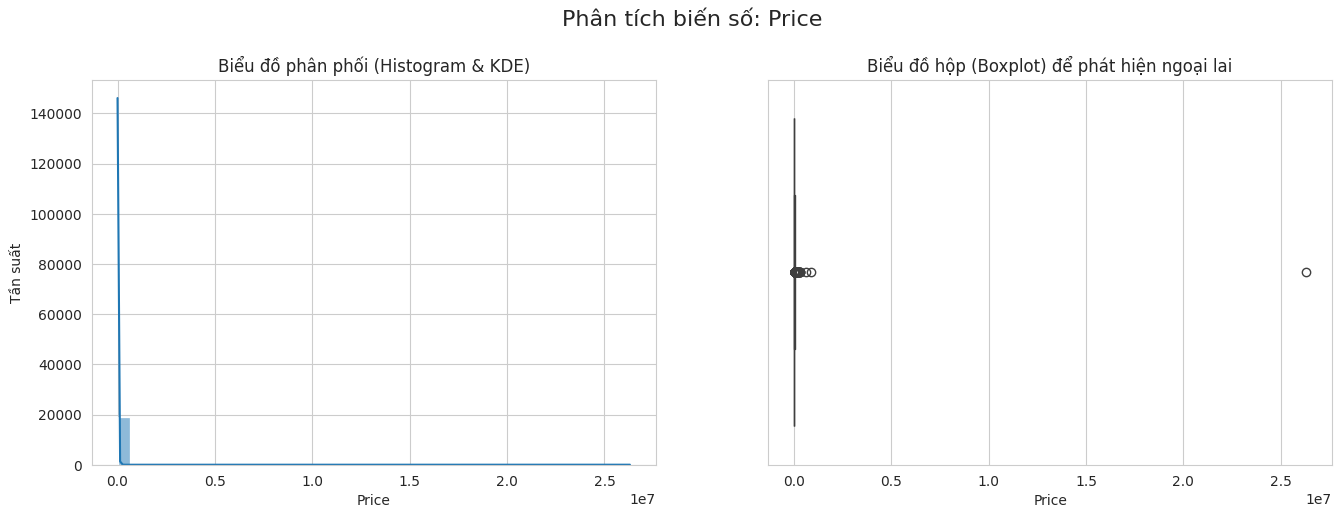

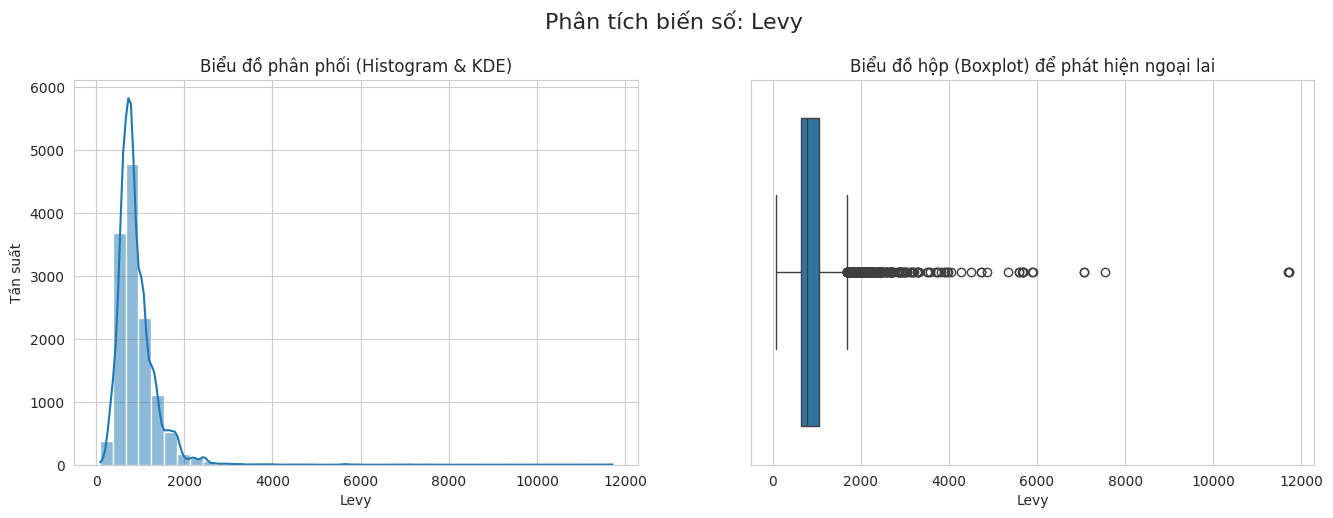

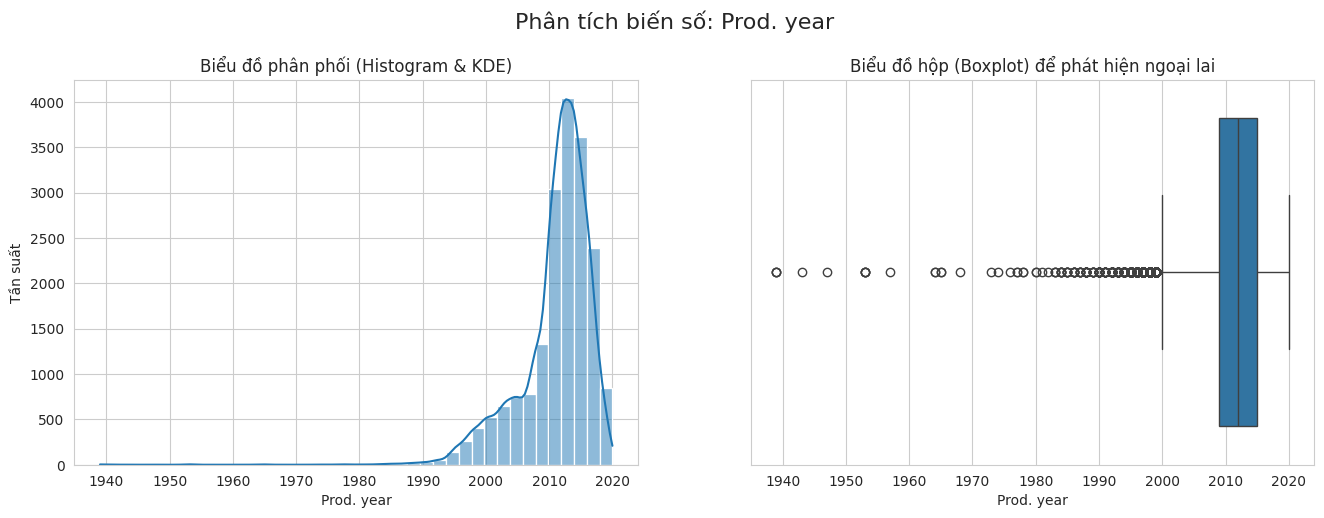

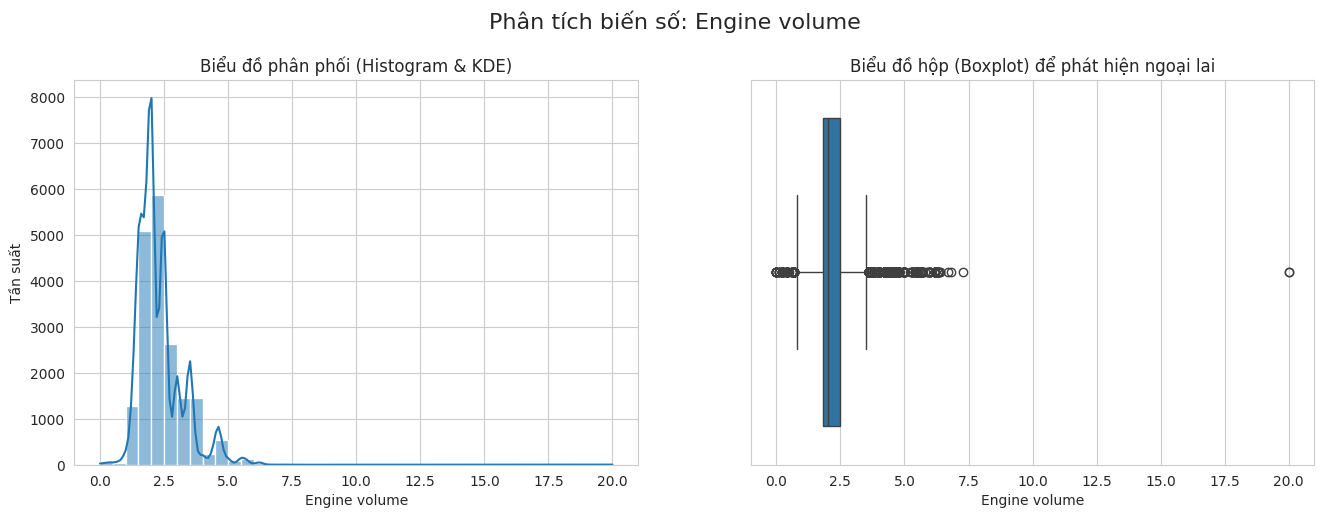

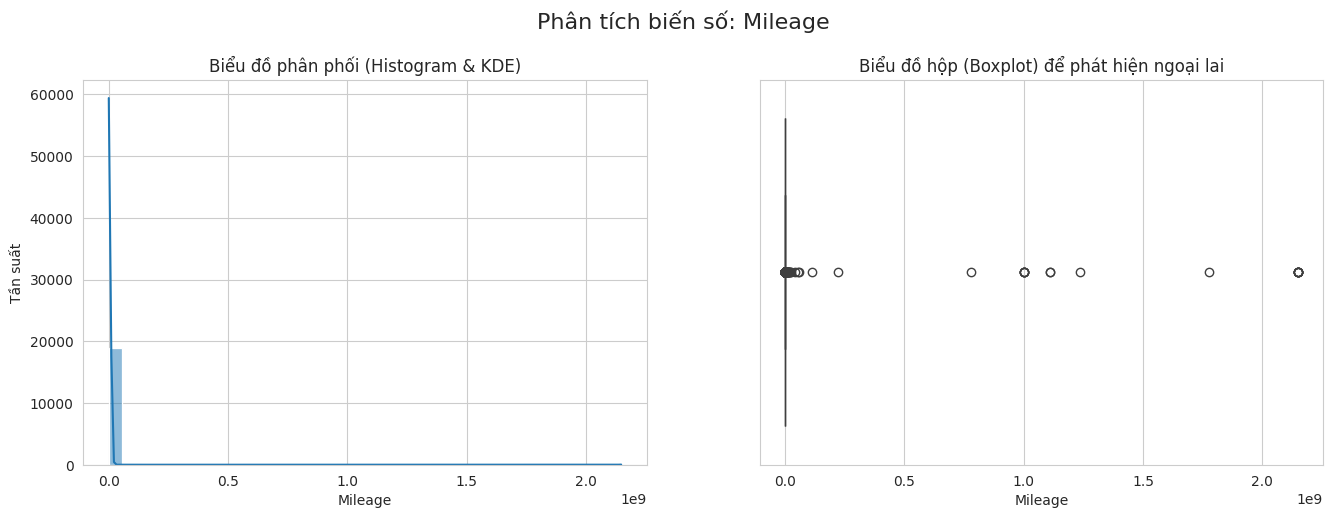

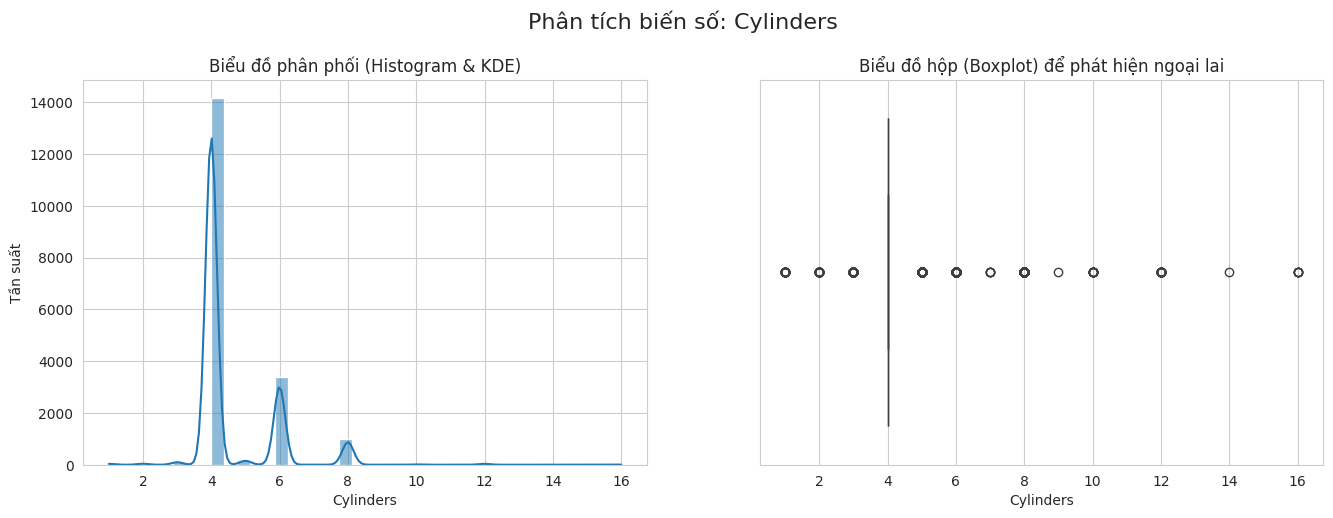

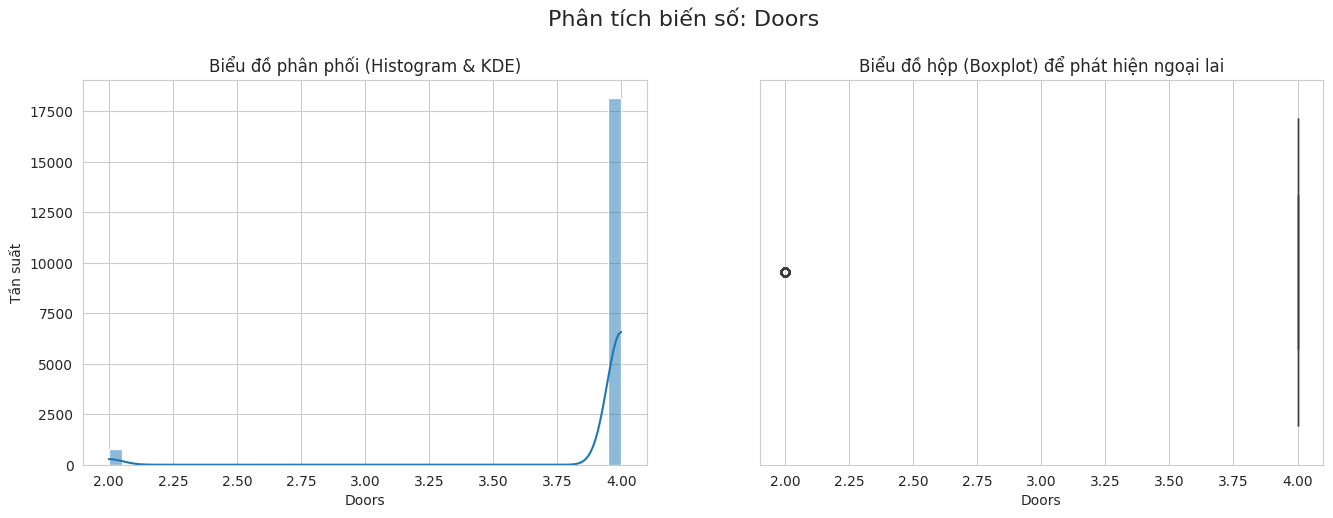

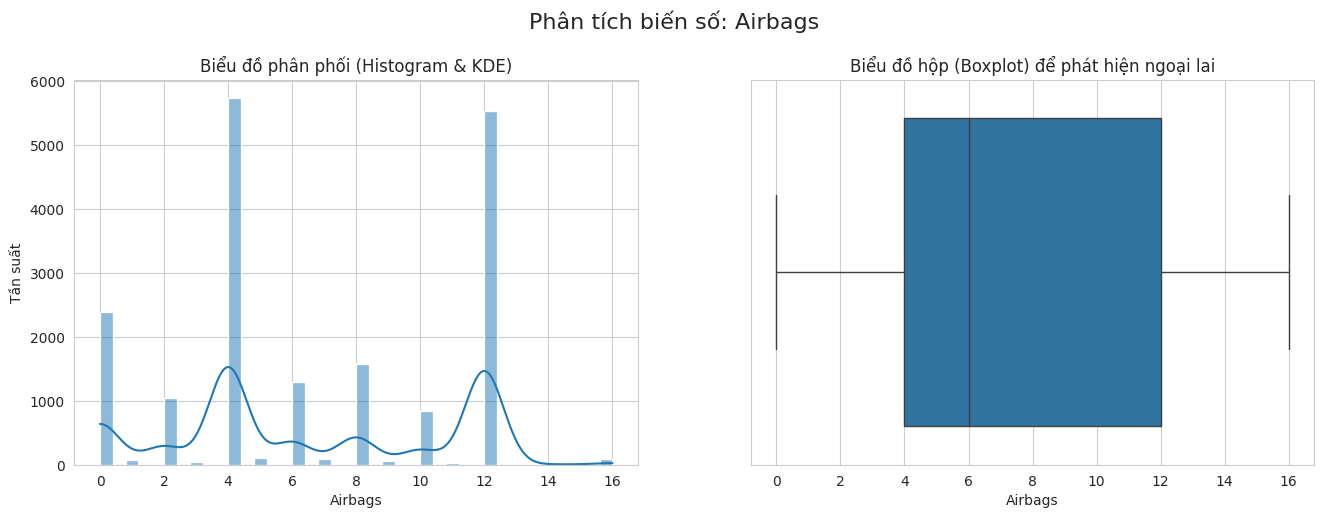

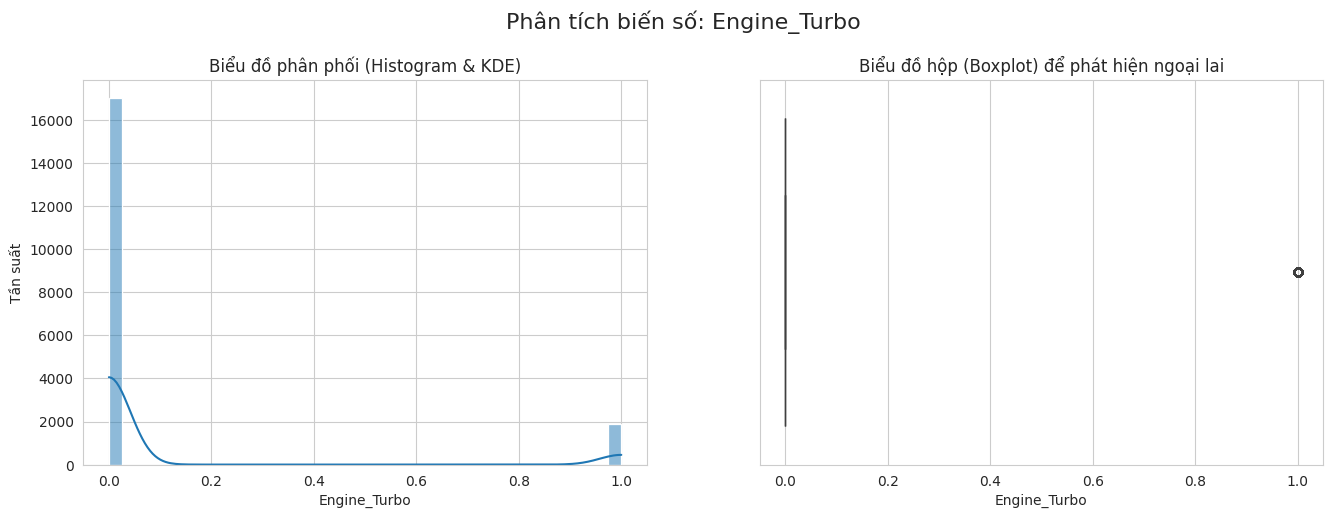

In [13]:
# Lấy danh sách các cột số (loại bỏ cột ID vì không có ý nghĩa thống kê)
numerical_cols = df.select_dtypes(include=np.number).columns.drop('ID', errors='ignore')

print("--- Phân tích phân phối và phát hiện ngoại lai cho các biến số ---")

for col in numerical_cols:
    # Tạo một figure mới cho mỗi cột
    plt.figure(figsize=(16, 5))
    plt.suptitle(f'Phân tích biến số: {col}', fontsize=16, y=1.02)

    # Biểu đồ 1: Histogram + KDE để xem hình dạng phân phối
    plt.subplot(1, 2, 1)
    sns.histplot(df[col], kde=True, bins=40)
    plt.title('Biểu đồ phân phối (Histogram & KDE)')
    plt.xlabel(col)
    plt.ylabel('Tần suất')

    # Biểu đồ 2: Boxplot để phát hiện giá trị ngoại lai
    plt.subplot(1, 2, 2)
    sns.boxplot(x=df[col])
    plt.title('Biểu đồ hộp (Boxplot) để phát hiện ngoại lai')
    plt.xlabel(col)

    # Hiển thị cặp biểu đồ cho cột hiện tại
    plt.show()

#### **2.3.2 Phân phối của các biến phân loại (Categorical Features)**

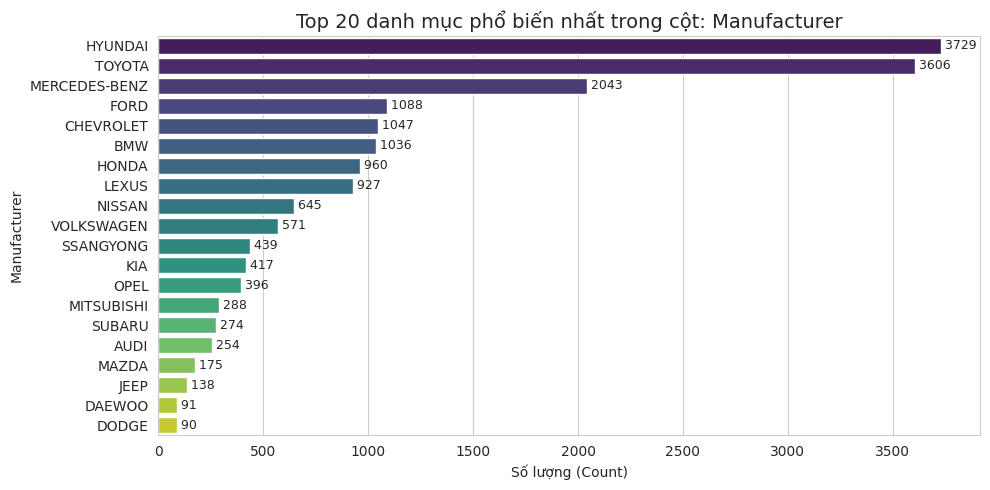

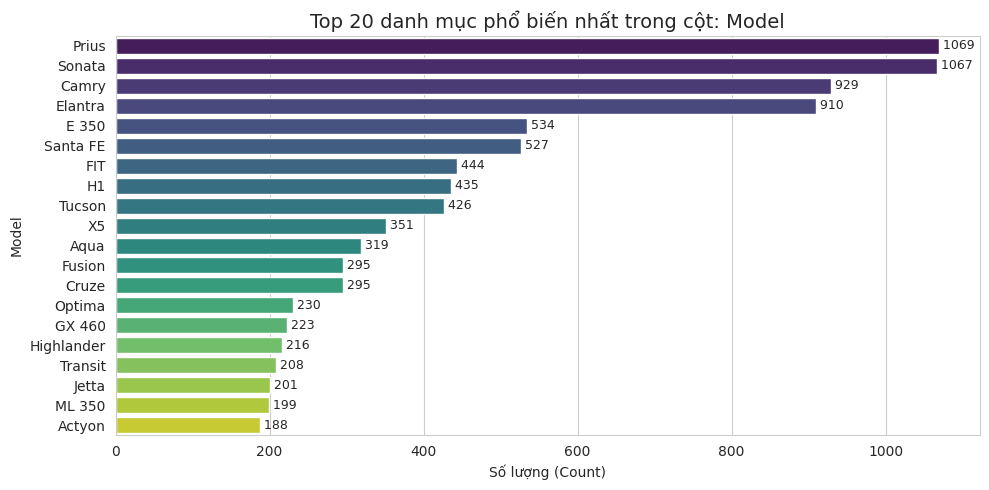

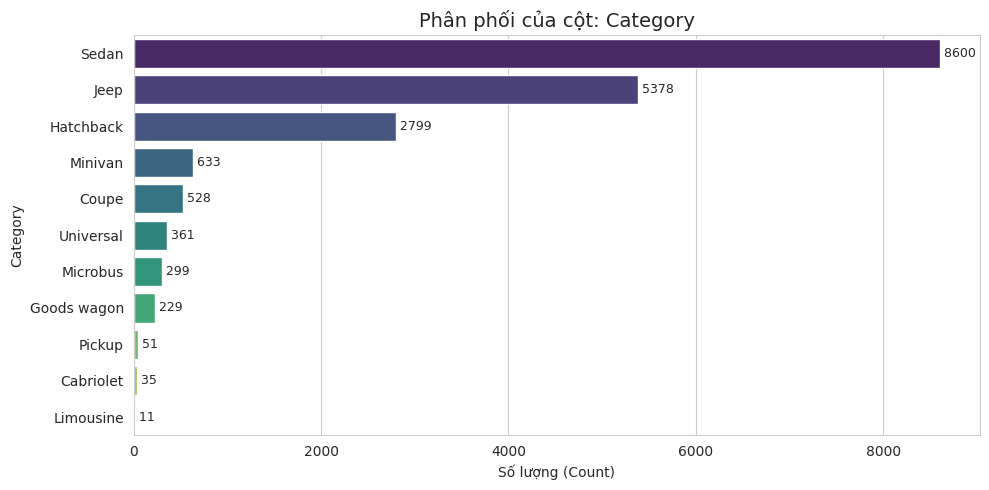

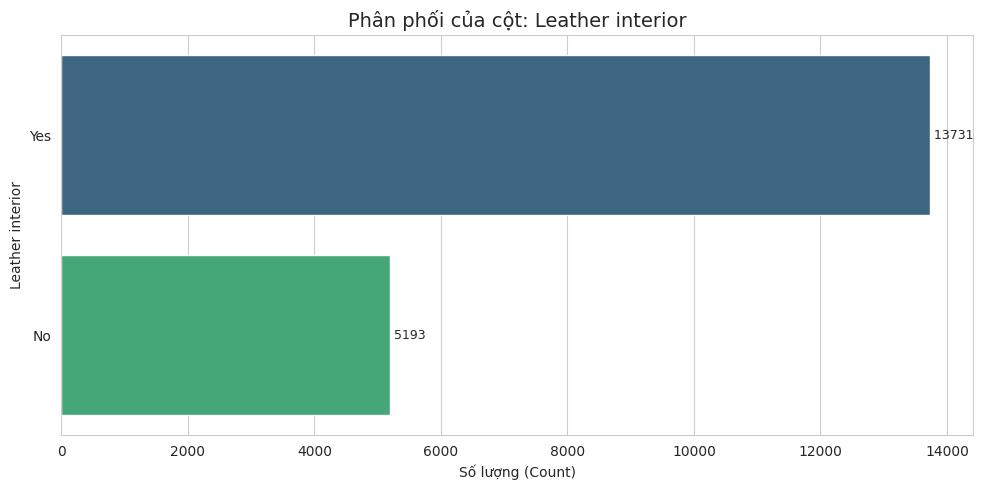

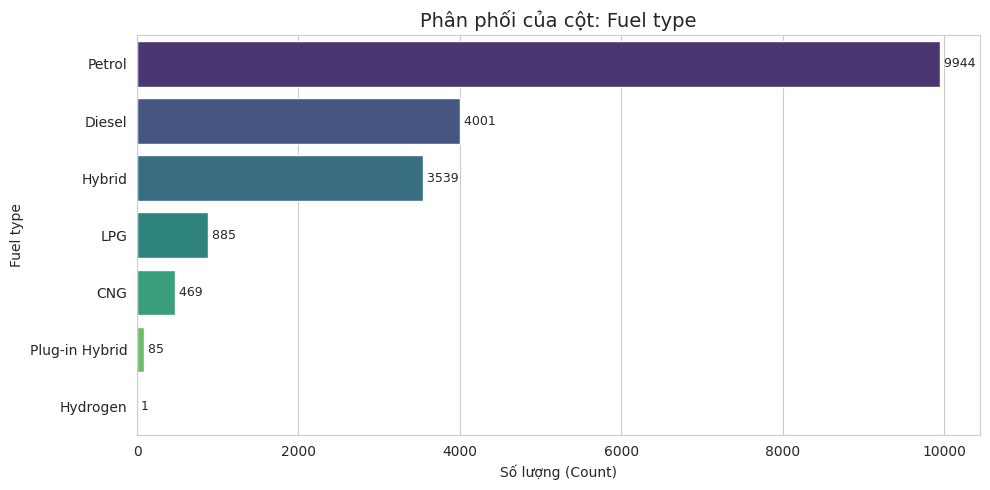

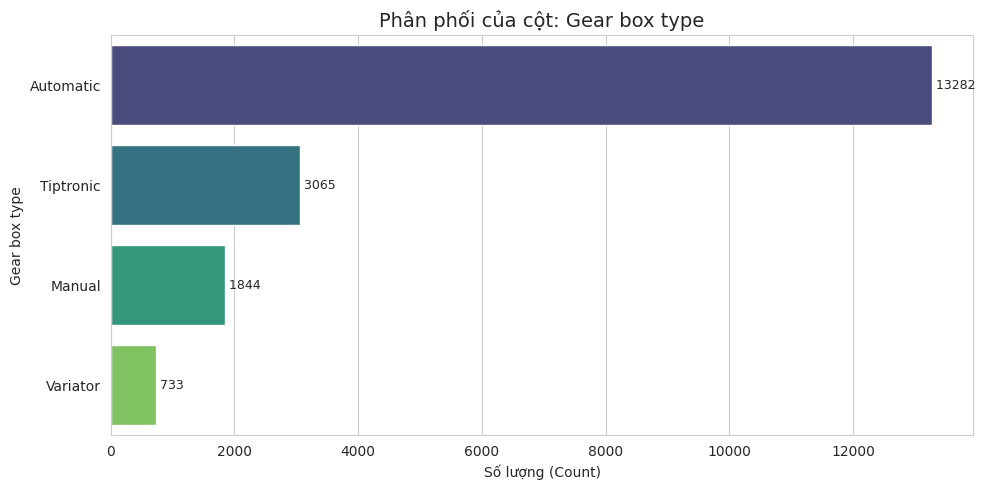

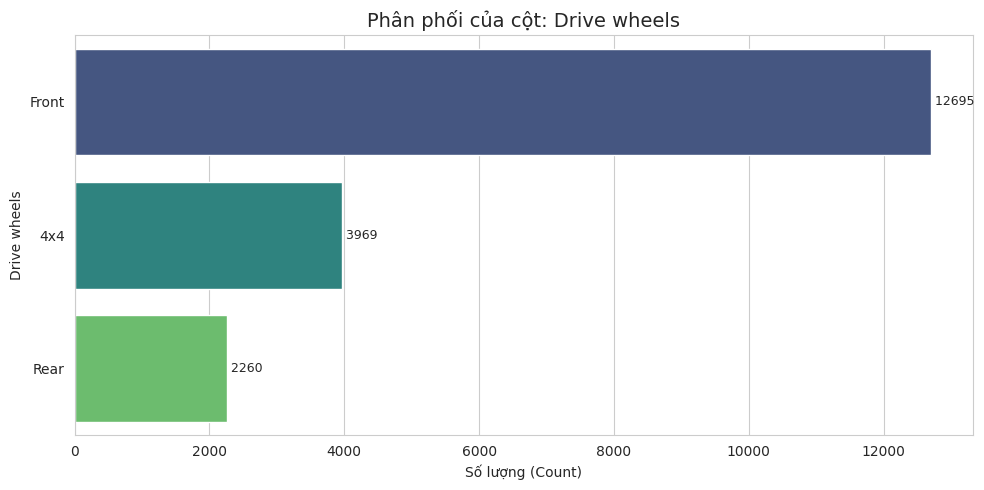

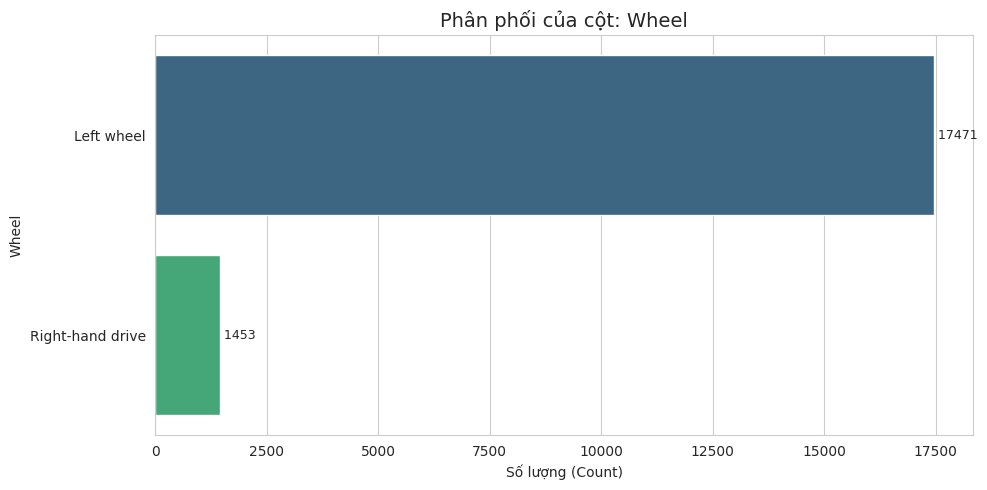

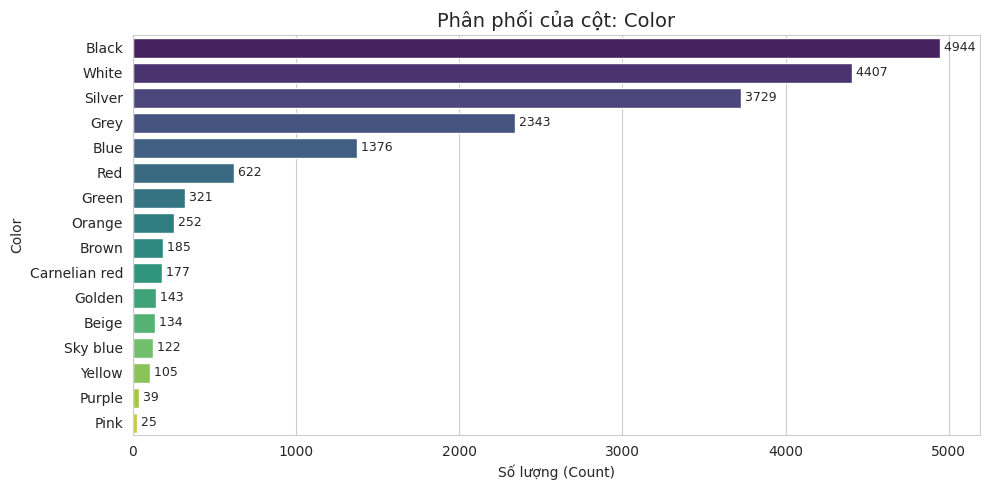

In [14]:
for col in categorical_cols:
    # Bỏ qua nếu cột không có giá trị duy nhất
    if df[col].nunique() == 0:
        continue

    num_categories = df[col].nunique()

    # Giảm kích thước biểu đồ cho gọn hơn
    # Chiều cao sẽ tự tăng nhẹ nếu có nhiều danh mục hơn
    fig_height = max(5, num_categories * 0.3) if 10 < num_categories <= 20 else 5
    plt.figure(figsize=(10, fig_height))

    # Lấy 20 giá trị phổ biến nhất nếu có quá nhiều danh mục
    if num_categories > 20:
        value_counts = df[col].value_counts().nlargest(20)
        title = f'Top 20 danh mục phổ biến nhất trong cột: {col}'
    else:
        value_counts = df[col].value_counts()
        title = f'Phân phối của cột: {col}'

    # Vẽ biểu đồ thanh ngang để dễ đọc tên các danh mục
    ax = sns.barplot(x=value_counts.values, y=value_counts.index, hue=value_counts.index, palette='viridis', legend=False)

    plt.title(title, fontsize=14)
    plt.xlabel('Số lượng (Count)', fontsize=10)
    plt.ylabel(col, fontsize=10)

    # Thêm nhãn số lượng vào cuối mỗi thanh
    for index, value in enumerate(value_counts):
        ax.text(value, index, f' {value}', va='center', fontsize=9)

    plt.tight_layout()
    plt.show()

#### **2.3.3 Tương quan**

<Axes: >

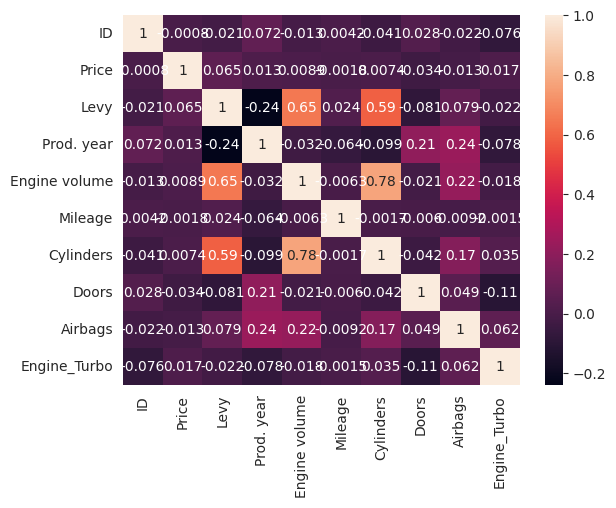

In [15]:
sns.heatmap(df.corr(numeric_only=True), annot=True)

In [16]:
sns.pairplot(df[:100])

KeyboardInterrupt: 

Error in callback <function _draw_all_if_interactive at 0x7931aefd1260> (for post_execute):


KeyboardInterrupt: 

Error in callback <function flush_figures at 0x7931aefa27a0> (for post_execute):


KeyboardInterrupt: 

In [ ]:
# Lấy danh sách các cột phân loại
categorical_cols_to_plot = df.select_dtypes(include=['object', 'bool']).columns

for col in categorical_cols_to_plot:
    if df[col].nunique() > 50:
        print(f"\nBỏ qua cột '{col}' vì có quá nhiều giá trị duy nhất ({df[col].nunique()}).")
        continue

    plt.figure(figsize=(12, 7))

    top_10_categories = df[col].value_counts().nlargest(10).index
    df_filtered = df[df[col].isin(top_10_categories)]

    # --- SỬA LỖI WARNING TẠI ĐÂY ---
    # Gán `x` cho `hue` và thêm `legend=False`
    sns.boxplot(
        data=df_filtered,
        x=col,
        y='Price',
        hue=col,            # Gán biến x cho hue
        palette='viridis',
        legend=False        # Tắt chú thích
    )

    plt.title(f'Phân phối giá xe theo danh mục của cột: {col}', fontsize=16)
    plt.xlabel(col, fontsize=12)
    plt.ylabel('Giá xe (Price)', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

In [ ]:
# Các cột này là số nhưng có ít giá trị duy nhất, có thể coi như phân loại
cols_to_analyze = ["Cylinders", "Airbags", "Engine volume"]

print("\n--- Phân tích mối quan hệ giữa các biến số đặc biệt và giá xe ---")

for col in cols_to_analyze:
    # Lấy 10 giá trị phổ biến nhất để biểu đồ không quá đông đúc
    top_values = df[col].value_counts().nlargest(10).index
    filtered_df = df[df[col].isin(top_values)]

    plt.figure(figsize=(12, 7))

    # --- THÊM MÀU SẮC VÀ SỬA LỖI WARNING TẠI ĐÂY ---
    sns.boxplot(
        data=filtered_df,
        x=col,
        y="Price",
        hue=col,            # Gán biến x cho hue
        palette='plasma',   # Thêm palette màu, ví dụ 'plasma'
        legend=False        # Tắt chú thích
    )

    plt.title(f'Phân phối giá xe theo giá trị của cột: {col}', fontsize=16)
    plt.xlabel(col, fontsize=12)
    plt.ylabel('Giá xe (Price)', fontsize=12)
    plt.tight_layout()
    plt.show()

### **2.4 Chuẩn bị dữ liệu cho mô hình (Data Preparation for Modeling)**

#### **2.4.1 Chia tập dữ liệu**

In [ ]:
# Tạo một bản sao để tránh SettingWithCopyWarning
df_prepared = df.copy()
X = df_prepared.drop(['ID', 'Price'], axis=1)
y = df_prepared['Price']

# Chia tập train/test 8:2
# Chia dữ liệu TRƯỚC KHI xử lý để tránh rò rỉ dữ liệu
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Áp dụng biến đổi log(1+price) cho biến mục tiêu y để nó có thể
y_train = np.log1p(y_train)
y_test = np.log1p(y_test)


print("--- Đã chia dữ liệu thành tập train và test ---")
print(f"Kích thước X_train: {X_train.shape}")
print(f"Kích thước X_test: {X_test.shape}")
print(f"Đã áp dụng biến đổi log1p cho y_train và y_test")

#### **2.4.2 Xử lí điểm ngoại lai và Missing value cho tập train**

In [ ]:
# Các cột đặc trưng cần xử lý ngoại lai
cols_to_clean = ["Mileage", "Levy"]

# 1. Xử lý ngoại lai cho các đặc trưng trong X_train
for col in cols_to_clean:
    # 1. Học các ngưỡng từ tập huấn luyện (X_train)
    q1 = X_train[col].quantile(0.25)
    q3 = X_train[col].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - (1.5 * iqr)
    upper_bound = q3 + (1.5 * iqr)

    print(f"Cột '{col}': Ngưỡng dưới = {lower_bound:.2f}, Ngưỡng trên = {upper_bound:.2f}. Áp dụng cho tập train.")

    # 2. Áp dụng các ngưỡng để "cắt" giá trị CHỈ trên tập train
    X_train[col] = X_train[col].clip(lower=lower_bound, upper=upper_bound)
    # Tập X_test được giữ nguyên

q1_price = y_train.quantile(0.25)
q3_price = y_train.quantile(0.75)
iqr_price = q3_price - q1_price
lower_bound_price = q1_price - (1.5 * iqr_price)
upper_bound_price = q3_price + (1.5 * iqr_price)

print(f"Cột 'Price': Ngưỡng dưới = {lower_bound_price:.2f}, Ngưỡng trên = {upper_bound_price:.2f}. Áp dụng cho tập train.")

# 2. Áp dụng các ngưỡng để "cắt" giá trị CHỈ trên tập train
y_train = y_train.clip(lower=lower_bound_price, upper=upper_bound_price)
# Tập y_test được giữ nguyên
print("\n--- Xử lý ngoại lai trên tập huấn luyện hoàn tất! ---")

# --- Xử lý missing value levy ----

# Tính median TỪ TẬP TRAIN
levy_median_train = X_train['Levy'].median()
# Điền giá trị thiếu TRÊN TẬP TRAIN
X_train['Levy'] = X_train['Levy'].fillna(levy_median_train)
print(f"Đã xử lý missing value cho 'Levy' trên tập train bằng median ({levy_median_train:.2f}).")

print("Tập test được giữ nguyên để phản ánh dữ liệu thực tế.")

## **3. Trích xuất đặc trưng và giảm số chiều dữ liệu**

### **3.1 Trích xuất đặc trưng**

In [ ]:
print("--- Dataset trước khi trích xuất đặc trưng ---")
display(X_train.head())
# # ---  Feature Engineering: Tạo cột 'Car_Age' ---

def add_car_age(df, current_year=2025, drop_cols=True):
    """
    Tạo đặc trưng Car_Age từ cột 'Prod. year' và tùy chọn loại bỏ cột ID + Prod. year
    Parameters:
        df (pd.DataFrame): DataFrame gốc
        current_year (int): Năm hiện tại (mặc định = 2025)
        drop_cols (bool): Có loại bỏ cột ['ID', 'Prod. year'] hay không
    Returns:
        pd.DataFrame: DataFrame đã thêm Car_Age và loại bỏ cột không cần thiết (nếu chọn)
    """
    if 'Prod. year' not in df.columns:
        raise ValueError("DataFrame không có cột 'Prod. year'!")
    # Tạo đặc trưng Car_Age
    df['Car_Age'] = current_year - df['Prod. year']
    print("✅ Đã tạo đặc trưng 'Car_Age'.")
    # Loại bỏ cột không cần thiết
    if drop_cols:
        cols_to_drop = [c for c in ['ID', 'Prod. year'] if c in df.columns]
        df = df.drop(columns=cols_to_drop)
        print(f"🗑️ Đã loại bỏ các cột: {cols_to_drop}")

    return df

#display(X_test.head())

#trích xuất đặc trưng tập train và tập test
X_train = add_car_age(X_train, current_year=2025, drop_cols=True)
X_test = add_car_age(X_test, current_year=2025, drop_cols=True)

display(X_train.head())
#display(X_test.head())

### **3.2 Lựa chọn đặc trưng( Feature Selection)**

In [ ]:
print("--- Lựa chọn đặc trưng ---")
def select(X_train, X_test):
    # Danh sách đặc trưng cần chọn
    selected_features = [
    'Levy', 'Manufacturer', 'Model', 'Category', 'Fuel type',
    'Engine volume', 'Cylinders', 'Gear box type',
    'Drive wheels', 'Airbags', 'Car_Age'
    ]

    # Giữ lại các cột mong muốn trong cả train và test
    X_train_selected = X_train[selected_features].copy()
    X_test_selected = X_test[selected_features].copy()
    print(f"Đã chọn {len(selected_features)} đặc trưng cho mô hình.")

    return X_train_selected, X_test_selected

X_train, X_test = select(X_train, X_test)

display(X_train.head())
display(X_test.head())


### **3.3 Feature Transformation**
Trong phần này, chúng ta sẽ thực hiện các bước **biển đổi** cuối cùng để chuẩn bị dữ liệu trước khi đưa vào mô hình:
1.  **Encoding:** Mã hóa các biến phân loại bằng One-Hot Encoding.
2.  **Scaling:** Chuẩn hóa các biến số bằng `StandardScaler`.
3.  **Giảm số chiều**

In [ ]:
# 1) Xác định cột
numerical_features = X_train.select_dtypes(include=np.number).columns
categorical_features = X_train.select_dtypes(include=['object', 'bool']).columns

# 2) Thêm imputer (rất quan trọng), scaler, OHE

# Numeric pipeline
num_steps = [("imputer", SimpleImputer(strategy="median"))]
if CONFIG["scaler"] == "standard":
    num_steps.append(("scaler", StandardScaler()))
elif CONFIG["scaler"] == "minmax":
    num_steps.append(("scaler", MinMaxScaler(feature_range=CONFIG["minmax_range"])))
numeric_transformer = Pipeline(num_steps)

# Categorical pipeline
categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))  # giữ mặc định sparse=True
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='drop'
)

# 3) Fit/transform
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed  = preprocessor.transform(X_test)
print("Shapes:", X_train_processed.shape, X_test_processed.shape)

# 4) PCA đúng cách: fit trên train, transform test
def fit_pca_to_variance(X_train_proc, variance_threshold=CONFIG['pca_variance_keep'], random_state=42):
    # Chuẩn bị dense (PCA không nhận sparse)
    Xtr = X_train_proc.toarray() if hasattr(X_train_proc, "toarray") else X_train_proc

    pca_full = PCA(random_state=random_state)
    pca_full.fit(Xtr)
    cum = np.cumsum(pca_full.explained_variance_ratio_)
    n_components = int(np.searchsorted(cum, variance_threshold) + 1)

    pca = PCA(n_components=n_components, random_state=random_state)
    Xtr_red = pca.fit_transform(Xtr)
    return pca, Xtr_red, n_components, cum

print(f"Giữ lại {int(CONFIG['pca_variance_keep']*100)}% phương sai")
pca, X_train_pca, n_comp, cum_var = fit_pca_to_variance(X_train_processed, CONFIG["pca_variance_keep"])

Xte_dense = X_test_processed.toarray() if hasattr(X_test_processed, "toarray") else X_test_processed
X_test_pca = pca.transform(Xte_dense)
print("Train/Test reduced shapes:", X_train_pca.shape, X_test_pca.shape)


## **4. Huấn luyện Mô hình (Model Training)**

Trong phần này, chúng ta sẽ huấn luyện các mô hình học máy khác nhau để dự đoán giá xe dựa trên các đặc trưng đã được xử lý.

### **4.1 Huấn luyện 3 model**


In [ ]:
# ---- Hàm chọn model theo tên (giữ tối giản) ----
def get_model_by_name(name: str):
    name = name.lower()
    if name == "linear":
        return LinearRegression()
    if name == "svr":
        return SVR()
    if name == "rf":
        return RandomForestRegressor(random_state=42, n_jobs=-1)
    raise ValueError("model_name phải là 'linear' | 'svr' | 'rf'.")

# ---- Tạo pipeline chỉ có 'model' (để dùng param 'model__*') ----
chosen_name_model = CONFIG["model_name"]
base_model = get_model_by_name(chosen_name_model)
pipe_model = Pipeline(steps=[("model", base_model)])
print("Mô hình đang huấn luyện", chosen_name_model)

# ---- Lấy param grid phù hợp tên model ----
param_grid = CONFIG["param_grids"].get(chosen_name_model, {})

# ---- Train (GridSearch nếu có param_grid; ngược lại fit trực tiếp) ----
if param_grid:  # có hyperparams để search
    cv = KFold(n_splits=CONFIG["cv_folds"], shuffle=True, random_state=42)
    gs = GridSearchCV(
        estimator=pipe_model,
        param_grid=param_grid,
        scoring="neg_root_mean_squared_error",
        cv=cv,
        n_jobs=-1,
        verbose=1
    )
    gs.fit(X_train_pca, y_train)
    best_est = gs.best_estimator_
    print(f"[{chosen_name_model}] Best params:", gs.best_params_)
else:  # không có hyperparams (vd Linear)
    best_est = pipe_model.fit(X_train_pca, y_train)

# ---- Dự đoán & đánh giá trên TEST ----
y_pred = best_est.predict(X_test_pca)
label = chosen_name_model.upper() if chosen_name_model != "rf" else "Random Forest"
print(f"--- Kết quả {label} ---")
print_metrics(y_test, y_pred, label=label)

## **5. Đánh giá mô hình (Model Evaluation)**

Trong phần này, chúng ta sẽ sử dụng mô hình đã được huấn luyện cho tập test để kiểm tra độ chính xác của các mô hình.# New Section

### **5.1 Hàm đánh giá mô hình**

In [ ]:
# Hàm print metrics dùng để xuất kết quả sau khi đã huấn luyện model
def print_metrics(y_true, y_pred, label='Model'):
        y_true_orig = np.expm1(y_true)
        y_pred_orig = np.expm1(y_pred)
        mae = mean_absolute_error(y_true_orig, y_pred_orig)
        rmse = np.sqrt(mean_squared_error(y_true_orig, y_pred_orig))
        r2 = r2_score(y_true, y_pred)  # R2 on log
        print(f"{label}: MAE={mae:,.2f}, RMSE={rmse:,.2f}, R2(on log)={r2:.4f}")

### **5.2 Dự đoán và đánh giá mô hình trên tập test**



In [ ]:
# ---- Dự đoán & đánh giá trên TEST ----
y_pred = best_est.predict(X_test_pca)
label = chosen_name_model.upper() if chosen_name_model != "rf" else "Random Forest"
print(f"--- Kết quả {label} ---")
print_metrics(y_test, y_pred, label=label)

### **5.3 Biểu đồ đánh giá mô hình trên tập test**

In [ ]:
def plot_simple_diagnostics_for_trained(best_pipe: Pipeline,
                                        Xtr, Xte, ytr, yte,
                                        model_label="Model",
                                        log_target=True,
                                        cv_folds=5):
    """
    - In R2 train/test + CV mean (trên dữ liệu đã PCA).
    - Vẽ residual (train) + y_test vs y_pred_test (ở đơn vị gốc nếu log_target=True).
    """
    # Dự đoán
    y_pred_tr = best_pipe.predict(Xtr)
    y_pred_te = best_pipe.predict(Xte)

    # Điểm số R² trên log-space (đúng với cách bạn đang train)
    r2_tr = r2_score(ytr, y_pred_tr)
    r2_te = r2_score(yte, y_pred_te)
    # CV (cần refit; acceptable vì chạy nhanh trên Xtr đã giảm chiều)
    cv_scores = cross_val_score(best_pipe, Xtr, ytr, cv=cv_folds, scoring="r2")
    print(f"{model_label} | R2 train: {r2_tr:.3f} | R2 test: {r2_te:.3f} | CV mean: {cv_scores.mean():.3f}")

    # Quy về đơn vị gốc để trực quan
    ytr_real  = np.expm1(ytr);  yptr_real = np.expm1(y_pred_tr)
    yte_real  = np.expm1(yte);  ypte_real = np.expm1(y_pred_te)

    # Plot giống concept hàm bạn (residual train + scatter test)
    fig, ax = plt.subplots(1, 2, figsize=(10, 4))
    ax[0].set_title('Residual Plot of Train samples')
    sns.kdeplot(ytr_real - yptr_real, fill=True, ax=ax[0])
    ax[0].set_xlabel('y_train - y_pred_train')

    ax[1].set_title('y_test vs y_pred_test')
    ax[1].scatter(yte_real, ypte_real, s=12, alpha=0.5)
    m = float(min(yte_real.min(), ypte_real.min()))
    M = float(max(yte_real.max(), ypte_real.max()))
    ax[1].plot([m, M], [m, M], ls="--", lw=1)
    ax[1].set_xlabel('y_test'); ax[1].set_ylabel('y_pred_test')

    plt.tight_layout()
    plt.show()

# Gọi trực tiếp cho model đã train theo CONFIG
model_label = chosen_name_model.upper() if chosen_name_model != "rf" else "Random Forest"
plot_simple_diagnostics_for_trained(
    best_pipe=best_est,
    Xtr=X_train_pca, Xte=X_test_pca,
    ytr=y_train, yte=y_test,
    model_label=model_label,
    log_target=True,        # bạn đang dùng log1p cho y
    cv_folds=5
)

### **5.4 Nhận xét mô hình trên tập test**

Sau khi chạy các tập test trên trên các mô hình thì có thể thấy mô hình dự đoán chính xác nhất là mô hình Random Forest với các thông số là ..... còn mô hình dự đoán tệ nhất đó là mô hình linear regression với .......

** **